# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups   
Sample_028  Q7Z3B1              21.307
Sample_124  P02792              16.100
Sample_168  A0A087X0D5;P09668   15.767
Sample_099  P29120;P29120-2     17.229
Sample_172  P07585              18.939
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups   
Sample_168  D6RF35              20.576
Sample_033  A0A087X240;P52803   16.607
Sample_025  Q8NFP4;Q8NFP4-2     17.244
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.197
            A0A075B6Q5                 14.403
            A0A075B6R2                 13.408
            A0A075B6S5                 13.353
            A0A087WSY4                 13.022
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.894
            Q9UI40;Q9UI40-2            12.543
            Q9UIW2                     14.842
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.462
            Q9UP79                     13.274
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.902,15.050,16.842,19.863,16.020,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.355,19.067,...,15.528,15.576,14.661,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.061,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.885,17.705,17.039,16.223,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.092,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.811,15.345,17.084,18.708,14.249,19.433,11.977,11.177
Sample_207,15.739,16.877,15.469,16.898,14.672,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.181,12.696,13.055,13.616,13.583,12.719,14.859,12.808,12.578,13.283
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.800,19.067,16.127,...,12.727,13.386,12.895,13.538,13.228,14.187,13.463,11.852,11.099,13.672
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.006,12.666,12.427,12.828,12.476,11.280,13.527,12.362,13.299,12.694
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.930,12.077,12.851,12.976,12.732,13.149,13.351,11.959,12.866,12.883
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.838,12.914,13.942,14.711,13.290,12.591,11.901,12.726,11.551,13.372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.301,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 359.50it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.61it/s]

100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.77it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.31it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.67it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.20it/s]

100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.13it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.37it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.16it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

100%|██████████| 6/6 [00:01<00:00,  3.99it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.34it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.45it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.51it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.09it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.79it/s]

100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.32it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.37it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.64it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.34it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.38it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.26it/s]

100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.98it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.28it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.56it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.03it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.74it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.39it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.41it/s]

100%|██████████| 9/9 [00:01<00:00,  4.34it/s]

100%|██████████| 9/9 [00:01<00:00,  4.84it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.12it/s]

 30%|███       | 3/10 [00:00<00:01,  6.15it/s]

 40%|████      | 4/10 [00:00<00:01,  5.09it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.73it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.57it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.83it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.83it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.97it/s]

100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.16it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.23it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.93it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.62it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.20it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.22it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.75it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.72it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.57it/s]

100%|██████████| 11/11 [00:02<00:00,  3.62it/s]

100%|██████████| 11/11 [00:02<00:00,  4.12it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.30it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.23it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.43it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.95it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.71it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.13it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.14it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.03it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.67it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.81it/s]

100%|██████████| 12/12 [00:02<00:00,  3.84it/s]

100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.93it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.42it/s]

 31%|███       | 4/13 [00:00<00:01,  5.49it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.17it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.92it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.92it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.30it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.39it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.84it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.99it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.20it/s]

100%|██████████| 13/13 [00:02<00:00,  4.14it/s]

100%|██████████| 13/13 [00:02<00:00,  4.57it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.22it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.68it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.72it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.43it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.38it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.40it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.51it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.67it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.32it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.41it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.49it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.84it/s]

100%|██████████| 14/14 [00:03<00:00,  4.06it/s]

100%|██████████| 14/14 [00:03<00:00,  4.12it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.46it/s]

 20%|██        | 3/15 [00:00<00:01,  6.41it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.60it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.98it/s]

 40%|████      | 6/15 [00:01<00:02,  4.25it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.17it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.25it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.36it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.18it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.52it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.65it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.67it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.57it/s]

100%|██████████| 15/15 [00:03<00:00,  3.69it/s]

100%|██████████| 15/15 [00:03<00:00,  4.15it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.067 0.027          0.787 0.323       0.127   
2             0.005 0.005      0.044 0.017          0.673 0.101       0.606   
3             0.005 0.005      0.059 0.026          0.693 0.089       0.647   
4             0.004 0.003      0.044 0.015          0.703 0.089       0.644   
5             0.005 0.005      0.047 0.019          0.690 0.094       0.637   
6             0.006 0.007      0.063 0.025          0.764 0.097       0.727   
7             0.004 0.003      0.049 0.018          0.765 0.095       0.730   
8             0.005 0.006      0.046 0.016          0.834 0.082       0.818   
9             0.004 0.002      0.039 0.011          0.829 0.088       0.818   
10            0.004 0.003      0.038 0.010          0.829 0.084       0.818   
11            0.004 0.002      0.037 0.006          0.825 0.083       0.815   
12            0.004 0.001      0.039 0.013          0.831 0.080       0.826   
13            0.004 0.002      0.035 0.003          0.826 0.082       0.819   
14            0.004 0.002      0.036 0.009          0.826 0.080       0.820   
15            0.003 0.001      0.028 0.009          0.821 0.082       0.820   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.211 0.128                  0.556 0.043        0.850   
2          0.112   0.633 0.095                  0.694 0.075        0.779   
3          0.117   0.663 0.089                  0.717 0.070        0.791   
4          0.123   0.665 0.090                  0.720 0.069        0.788   
5          0.128   0.656 0.097                  0.712 0.075        0.783   
6          0.104   0.740 0.080                  0.779 0.065        0.852   
7          0.105   0.741 0.080                  0.780 0.066        0.851   
8          0.106   0.822 0.076                  0.849 0.064        0.910   
9          0.104   0.820 0.077                  0.846 0.066        0.908   
10         0.104   0.820 0.075                  0.846 0.064        0.909   
11         0.107   0.816 0.077                  0.843 0.066        0.908   
12         0.103   0.824 0.070                  0.850 0.060        0.911   
13         0.107   0.818 0.074                  0.845 0.062        0.909   
14         0.095   0.818 0.063                  0.845 0.054        0.907   
15         0.093   0.816 0.064                  0.843 0.054        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.824 0.088        210.000 0.000  
2          0.075                  0.734 0.102        210.000 0.000  
3          0.076                  0.750 0.096        210.000 0.000  
4          0.079                  0.737 0.104        210.000 0.000  
5          0.081                  0.729 0.107        210.000 0.000  
6          0.071                  0.836 0.078        210.000 0.000  
7          0.072                  0.837 0.078        210.000 0.000  
8          0.055                  0.899 0.054        210.000 0.000  
9          0.056                  0.895 0.057        210.000 0.000  
10         0.055                  0.896 0.057        210.000 0.000  
11         0.056                  0.895 0.058        210.000 0.000  
12         0.055                  0.903 0.052        210.000 0.000  
13         0.056                  0.900 0.054        210.000 0.000  
14         0.055                  0.899 0.052        210.000 0.000  
15         0.054                  0.897 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 495.20it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.07it/s]

100%|██████████| 3/3 [00:00<00:00,  2.92it/s]

100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.93it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.68it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.40it/s]

100%|██████████| 5/5 [00:01<00:00,  4.51it/s]

100%|██████████| 5/5 [00:01<00:00,  4.89it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.26it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  6.68it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.69it/s]

100%|██████████| 6/6 [00:00<00:00,  5.73it/s]

100%|██████████| 6/6 [00:00<00:00,  6.17it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.42it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.24it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.62it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.22it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.96it/s]

100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.27it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.53it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.72it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.55it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.34it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.98it/s]

100%|██████████| 8/8 [00:01<00:00,  3.93it/s]

100%|██████████| 8/8 [00:01<00:00,  4.38it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.35it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.00it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.58it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.35it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.67it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.65it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.58it/s]

100%|██████████| 9/9 [00:01<00:00,  4.66it/s]

100%|██████████| 9/9 [00:01<00:00,  4.75it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 15.92it/s]

 40%|████      | 4/10 [00:00<00:00, 10.05it/s]

 60%|██████    | 6/10 [00:00<00:00,  8.36it/s]

 70%|███████   | 7/10 [00:00<00:00,  7.76it/s]

 80%|████████  | 8/10 [00:00<00:00,  7.26it/s]

 90%|█████████ | 9/10 [00:01<00:00,  7.15it/s]

100%|██████████| 10/10 [00:01<00:00,  7.17it/s]

100%|██████████| 10/10 [00:01<00:00,  7.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.86it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.21it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.58it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.59it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.14it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  4.00it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.85it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.79it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.87it/s]

100%|██████████| 11/11 [00:02<00:00,  3.74it/s]

100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 10.58it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.96it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.63it/s]

 50%|█████     | 6/12 [00:01<00:01,  5.54it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.29it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.26it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.11it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.07it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  5.18it/s]

100%|██████████| 12/12 [00:02<00:00,  4.88it/s]

100%|██████████| 12/12 [00:02<00:00,  5.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.91it/s]

 31%|███       | 4/13 [00:00<00:01,  7.99it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.30it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.21it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  6.90it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.81it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.67it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  7.01it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  7.25it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  7.44it/s]

100%|██████████| 13/13 [00:01<00:00,  7.59it/s]

100%|██████████| 13/13 [00:01<00:00,  7.42it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 13.90it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.62it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.98it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.48it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.27it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.62it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.79it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.47it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.18it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.00it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.77it/s]

100%|██████████| 14/14 [00:02<00:00,  4.64it/s]

100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.80it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.34it/s]

 40%|████      | 6/15 [00:00<00:00,  9.29it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.94it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.68it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.64it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.65it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.63it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.63it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.63it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.63it/s]

100%|██████████| 15/15 [00:01<00:00,  8.63it/s]

100%|██████████| 15/15 [00:01<00:00,  8.98it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.036 0.005          0.087 0.248       0.009   
2             0.005 0.004      0.052 0.022          0.650 0.115       0.483   
3             0.006 0.005      0.054 0.025          0.758 0.078       0.710   
4             0.005 0.004      0.044 0.016          0.777 0.083       0.734   
5             0.003 0.003      0.025 0.008          0.846 0.083       0.810   
6             0.003 0.001      0.025 0.006          0.835 0.086       0.814   
7             0.003 0.000      0.033 0.002          0.830 0.091       0.815   
8             0.003 0.000      0.033 0.003          0.824 0.091       0.815   
9             0.002 0.000      0.022 0.005          0.831 0.084       0.811   
10            0.002 0.000      0.023 0.004          0.827 0.082       0.820   
11            0.003 0.000      0.031 0.004          0.842 0.083       0.831   
12            0.003 0.001      0.027 0.006          0.838 0.083       0.830   
13            0.002 0.000      0.019 0.000          0.827 0.083       0.827   
14            0.003 0.001      0.027 0.008          0.829 0.087       0.829   
15            0.002 0.000      0.019 0.000          0.845 0.080       0.842   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.869   
2          0.114   0.544 0.090                  0.642 0.060        0.713   
3          0.103   0.728 0.070                  0.771 0.053        0.880   
4          0.103   0.749 0.069                  0.788 0.053        0.882   
5          0.098   0.823 0.071                  0.850 0.058        0.921   
6          0.096   0.820 0.069                  0.846 0.058        0.924   
7          0.092   0.818 0.069                  0.844 0.059        0.922   
8          0.103   0.814 0.074                  0.841 0.062        0.919   
9          0.102   0.816 0.072                  0.844 0.060        0.919   
10         0.098   0.820 0.071                  0.846 0.060        0.918   
11         0.094   0.833 0.069                  0.857 0.058        0.923   
12         0.094   0.830 0.067                  0.855 0.057        0.923   
13         0.097   0.823 0.069                  0.849 0.058        0.926   
14         0.104   0.824 0.071                  0.850 0.060        0.925   
15         0.097   0.839 0.065                  0.863 0.055        0.927   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.836 0.088        210.000 0.000  
2          0.081                  0.639 0.101        210.000 0.000  
3          0.044                  0.837 0.066        210.000 0.000  
4          0.045                  0.839 0.070        210.000 0.000  
5          0.040                  0.903 0.047        210.000 0.000  
6          0.040                  0.907 0.047        210.000 0.000  
7          0.041                  0.905 0.048        210.000 0.000  
8          0.043                  0.903 0.049        210.000 0.000  
9          0.043                  0.902 0.050        210.000 0.000  
10         0.045                  0.903 0.050        210.000 0.000  
11         0.044                  0.909 0.048        210.000 0.000  
12         0.044                  0.909 0.049        210.000 0.000  
13         0.043                  0.911 0.048        210.000 0.000  
14         0.043                  0.911 0.048        210.000 0.000  
15         0.042                  0.914 0.048 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1117.88it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 66.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 52.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.82it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.99it/s]

100%|██████████| 5/5 [00:00<00:00, 43.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 43.16it/s]

100%|██████████| 6/6 [00:00<00:00, 41.25it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 44.15it/s]

100%|██████████| 7/7 [00:00<00:00, 41.11it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.74it/s]

100%|██████████| 8/8 [00:00<00:00, 40.08it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 43.83it/s]

100%|██████████| 9/9 [00:00<00:00, 39.43it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.49it/s]

100%|██████████| 10/10 [00:00<00:00, 38.27it/s]

100%|██████████| 10/10 [00:00<00:00, 38.87it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 43.66it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.16it/s]

100%|██████████| 11/11 [00:00<00:00, 38.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.56it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.24it/s]

100%|██████████| 12/12 [00:00<00:00, 38.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.76it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.12it/s]

100%|██████████| 13/13 [00:00<00:00, 37.93it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.73it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.10it/s]

100%|██████████| 14/14 [00:00<00:00, 36.96it/s]

100%|██████████| 14/14 [00:00<00:00, 37.73it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.69it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.24it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 36.77it/s]

100%|██████████| 15/15 [00:00<00:00, 37.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.679 0.108       0.536   
3             0.002 0.000      0.019 0.000          0.673 0.100       0.585   
4             0.002 0.000      0.019 0.000          0.757 0.099       0.650   
5             0.002 0.000      0.019 0.000          0.790 0.099       0.687   
6             0.002 0.000      0.019 0.000          0.755 0.092       0.664   
7             0.002 0.000      0.019 0.000          0.764 0.086       0.668   
8             0.002 0.000      0.019 0.001          0.752 0.076       0.666   
9             0.002 0.000      0.019 0.000          0.727 0.077       0.684   
10            0.002 0.000      0.019 0.000          0.713 0.079       0.672   
11            0.002 0.000      0.019 0.001          0.721 0.082       0.686   
12            0.002 0.000      0.019 0.000          0.694 0.087       0.680   
13            0.002 0.000      0.019 0.001          0.696 0.089       0.672   
14            0.002 0.000      0.019 0.000          0.706 0.091       0.661   
15            0.002 0.000      0.019 0.000          0.720 0.099       0.667   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.734   
2          0.095   0.593 0.082                  0.673 0.060        0.726   
3          0.102   0.620 0.080                  0.686 0.061        0.772   
4          0.123   0.693 0.089                  0.747 0.068        0.811   
5          0.107   0.729 0.077                  0.774 0.062        0.817   
6          0.113   0.701 0.089                  0.752 0.068        0.832   
7          0.108   0.708 0.083                  0.758 0.063        0.828   
8          0.106   0.702 0.080                  0.753 0.060        0.826   
9          0.114   0.700 0.081                  0.748 0.064        0.828   
10         0.117   0.687 0.087                  0.737 0.066        0.824   
11         0.099   0.700 0.077                  0.745 0.064        0.833   
12         0.120   0.682 0.091                  0.730 0.072        0.835   
13         0.109   0.679 0.083                  0.728 0.068        0.835   
14         0.114   0.677 0.085                  0.729 0.067        0.837   
15         0.116   0.687 0.089                  0.737 0.071        0.838   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.055                  0.675 0.075        210.000 0.000  
2          0.075                  0.658 0.094        210.000 0.000  
3          0.063                  0.722 0.075        210.000 0.000  
4          0.066                  0.761 0.087        210.000 0.000  
5          0.069                  0.774 0.090        210.000 0.000  
6          0.064                  0.792 0.079        210.000 0.000  
7          0.062                  0.787 0.078        210.000 0.000  
8          0.062                  0.785 0.077        210.000 0.000  
9          0.061                  0.779 0.077        210.000 0.000  
10         0.064                  0.774 0.080        210.000 0.000  
11         0.060                  0.789 0.077        210.000 0.000  
12         0.059                  0.796 0.067        210.000 0.000  
13         0.057                  0.796 0.066        210.000 0.000  
14         0.055                  0.793 0.068        210.000 0.000  
15         0.059                  0.795 0.072 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,3,11
score_time,1,3,8
test_precision,8,5,5
test_recall,12,15,5
test_f1,12,15,5
test_balanced_accuracy,12,15,5
test_roc_auc,12,15,15
test_average_precision,12,15,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.97it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.36it/s]

 40%|████      | 6/15 [00:00<00:00,  9.34it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.00it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.74it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.53it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.45it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.43it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.39it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.37it/s]

100%|██████████| 15/15 [00:01<00:00,  8.37it/s]

100%|██████████| 15/15 [00:01<00:00,  8.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.89it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.46it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.16it/s]

100%|██████████| 15/15 [00:00<00:00, 37.75it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.91it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.20it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.86it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.30it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.96it/s]

100%|██████████| 12/12 [00:01<00:00,  9.82it/s]

100%|██████████| 12/12 [00:01<00:00, 10.44it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


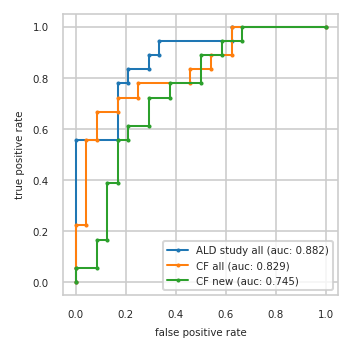

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.556  0.000 0.222  0.083 0.056
3          0.167 0.556  0.042 0.222  0.083 0.167
4          0.167 0.778  0.042 0.556  0.125 0.167
5          0.208 0.778  0.083 0.556  0.125 0.389
6          0.208 0.833  0.083 0.667  0.167 0.389
7          0.292 0.833  0.167 0.667  0.167 0.556
8          0.292 0.889  0.167 0.722  0.208 0.556
9          0.333 0.889  0.250 0.722  0.208 0.611
10         0.333 0.944  0.250 0.778  0.292 0.611
11         0.625 0.944  0.458 0.778  0.292 0.722
12         0.625 1.000  0.458 0.833  0.375 0.722
13         1.000 1.000  0.542 0.833  0.375 0.778
14           NaN   NaN  0.542 0.889  0.500 0.778
15           NaN   NaN  0.625 0.889  0.500 0.889
16           NaN   NaN  0.625 1.000  0.583 0.889
17           NaN   NaN  1.000 1.000  0.583 0.944
18           NaN   NaN    NaN   NaN  0.667 0.944
19           NaN   NaN    NaN   NaN  0.667 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,Q8NFY4;Q8NFY4-6,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
2,P09486,Q96GD0,A0A0G2JLV7;A0A0G2JM94;A0A0G2JMI0;A0A0G2JNK8;A0...
3,A6NFX8;Q9UKK9,P04075,A0A075B7B8
4,P10636-2;P10636-6,P61981,P31321
5,P14174,P25189;P25189-2,J3KSJ8;Q9UD71;Q9UD71-2
6,P61981,Q9Y2T3;Q9Y2T3-3,P05556;P05556-2;P05556-3;P05556-4;P05556-5
7,Q9Y2T3;Q9Y2T3-3,P15151-2,P51688
8,P63104,P14174,O95497


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


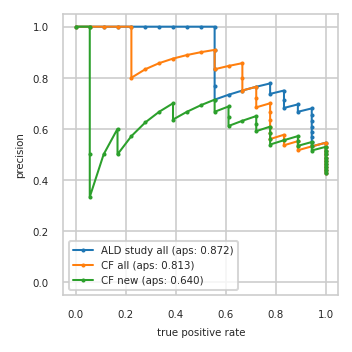

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.531 0.944     0.531 0.944     0.531 0.944
11         0.548 0.944     0.516 0.889     0.548 0.944
12         0.567 0.944     0.533 0.889     0.533 0.889
13         0.586 0.944     0.552 0.889     0.552 0.889
14         0.607 0.944     0.536 0.833     0.571 0.889
15         0.630 0.944     0.556 0.833     0.556 0.833
16         0.654 0.944     0.577 0.833     0.538 0.778
17         0.680 0.944     0.560 0.778     0.560 0.778
18         0.667 0.889     0.583 0.778     0.583 0.778
19         0.696 0.889     0.609 0.778     0.609 0.778
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.714 0.833     0.667 0.778     0.619 0.722
22         0.750 0.833     0.700 0.778     0.650 0.722
23         0.737 0.778     0.684 0.722     0.632 0.667
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.765 0.722     0.765 0.722     0.647 0.611
26         0.750 0.667     0.750 0.667     0.688 0.611
27         0.733 0.611     0.800 0.667     0.667 0.556
28         0.714 0.556     0.857 0.667     0.714 0.556
29         0.769 0.556     0.846 0.611     0.692 0.500
30         0.833 0.556     0.833 0.556     0.667 0.444
31         0.909 0.556     0.909 0.556     0.636 0.389
32         1.000 0.556     0.900 0.500     0.700 0.389
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


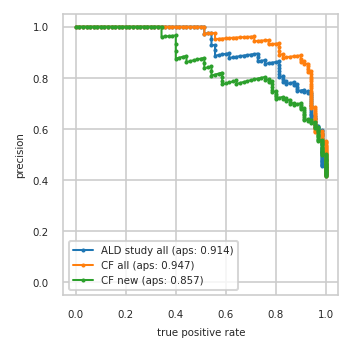

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


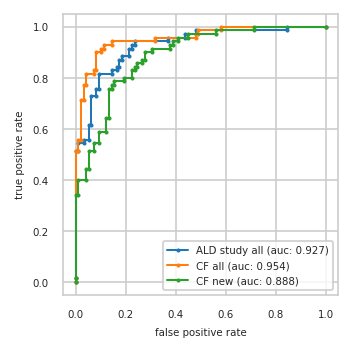

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}